In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from scenedetect import VideoManager, VideoCaptureAdapter
from scenedetect import SceneManager
from scenedetect import open_video, SceneManager, ContentDetector, StatsManager, ThresholdDetector, AdaptiveDetector
from moviepy.editor import VideoFileClip
import os 
from pytube import Playlist, YouTube
import concurrent.futures
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
def calculate_pixelwise_difference(frame1, frame2):
    """
    Calculate the pixel-wise difference between two frames.

    :param frame1: First frame.
    :param frame2: Second frame.
    :return: A matrix representing the pixel-wise difference.
    """
    # Ensure the frames are of the same shape
    if frame1.shape != frame2.shape:
        raise ValueError("Frames do not have the same shape.")

    # Calculate the absolute difference between the frames
    difference = cv2.absdiff(frame1, frame2)

    return difference

def get_random_frame(video, total_frames):
    """
    Get a random frame from the video.

    :param video: VideoCapture object.
    :param total_frames: Total number of frames in the video.
    :return: A randomly selected frame.
    """
    frame_number = random.randint(0, total_frames - 1)
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = video.read()
    if not ret:
        raise ValueError("Error reading the frame.")
    return frame

def calculate_frame_difference(frame1, frame2):
    """
    Calculate the pixel-wise difference between two frames and return its mean.

    :param frame1: First frame.
    :param frame2: Second frame.
    :return: Mean of the pixel-wise difference.
    """
    # # Convert frames to grayscale for simpler computation
    # gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    # gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Calculate the absolute difference between the frames
    difference = cv2.absdiff(frame1, frame2)

    return np.mean(difference)


10.27786060474537


(-0.5, 1279.5, 719.5, -0.5)

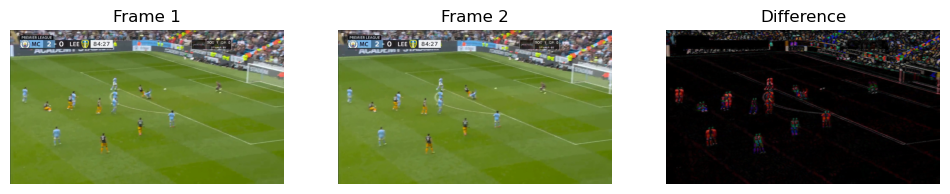

In [4]:
video_path = os.path.join('/Users/idotzhori/Desktop/Desktop - Ido’s Laptop/autoencoderlight/cleaned_highlights',random.choice(os.listdir('cleaned_highlights')))

video = cv2.VideoCapture(video_path)

total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

random_frame_number = random.randint(0, total_frames - 2)

video.set(cv2.CAP_PROP_POS_FRAMES, random_frame_number)

ret, frame1 = video.read()
ret, frame2 = video.read()

frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

diff = calculate_pixelwise_difference(frame1, frame2)
print(np.mean(diff))
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(frame1_rgb)
plt.title('Frame 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(frame2_rgb)
plt.title('Frame 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')


In [4]:
def find_scenes(video_path, video_manager, thresh, min_content, max_scene_length=15, min_scene_length=5):
    scene_manager = SceneManager()
    scene_manager.add_detector(AdaptiveDetector(adaptive_threshold=thresh, min_content_val=min_content))

    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager)
    scenes = scene_manager.get_scene_list()

    video_manager.release()

    # Calculate total video duration in seconds
    video_duration = video_manager.get_duration()[0].get_frames()/video_manager.get_duration()[0].get_framerate()

    adjusted_scenes = []
    framerate = video_manager.get_framerate()
    clip_number = 0
    for start, end in scenes:
        start_seconds = start.get_frames() / framerate
        end_seconds = end.get_frames() / framerate

        # Check if the scene's start and end times meet the specified criteria
        if start_seconds > 80 and (video_duration - end_seconds) > 80:
            scene_length = (end.get_frames() - start.get_frames()) / framerate
            if scene_length < max_scene_length and scene_length >= min_scene_length:
                adjusted_scenes.append((start, end))
                clip_number += 1
                # print(f"Clip {clip_number}: Start {start.get_timecode()}, End {end.get_timecode()}, Length {scene_length:.2f} seconds")

    return adjusted_scenes

def save_scene(scene, scene_number, video_path, output_dir):
    start_time = max(scene[0].get_seconds() + 0.75, 0)
    end_time = scene[1].get_seconds() - 0.2

    video_clip = VideoFileClip(video_path).subclip(start_time, end_time)
    output_path = os.path.join(output_dir, f"scene_{scene_number}.mp4")
    video_clip.write_videofile(output_path, codec="libx264", audio_codec='aac', verbose=False, logger=None)
    
def cut_scene(video_path, thresh, min_content, base_output_dir="cut_clips"):
    video_manager = VideoManager([video_path])

    video_file_name = os.path.splitext(os.path.basename(video_path))[0]
    output_dir = os.path.join(base_output_dir, video_file_name)

    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    scenes = find_scenes(video_path, video_manager, thresh, min_content)

    for i, scene in enumerate(scenes):
        save_scene(scene, i+1, video_path, output_dir)
        # print(f"Scene {i+1} saved: Start - {scene[0].get_timecode()}, End - {scene[1].get_timecode()}")

In [ ]:
video_manager = VideoManager(['/Users/idotzhori/Desktop/Highlight Detection/temp_download/1.mp4'])
scenes = find_scenes('/Users/idotzhori/Desktop/Highlight Detection/temp_download/1.mp4', video_manager, 0.9, 15)

In [5]:
def get_highlight_videos(playlist_url):
    playlist = Playlist(playlist_url)
    highlights_url = []
    for video in playlist.videos:
        if "PREMIER LEAGUE HIGHLIGHTS" in video.title:
            highlights_url.append(video.watch_url)
    return highlights_url

playlist_url = 'https://www.youtube.com/playlist?list=PLXEMPXZ3PY1hjUnuEJqxxYoRQLOEw6WFj'
highlights = get_highlight_videos(playlist_url)

KeyboardInterrupt: 

In [ ]:
with open('highlights.pkl', 'wb') as f:
    pickle.dump(highlights, f)

print("Highlights have been pickled.")

In [6]:
with open('highlights.pkl', 'rb') as f:
    highlights = pickle.load(f)

len(highlights)

380

In [7]:
def download_video(url, path='temp_download'):
    yt = YouTube(url)
    video = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    if not os.path.exists(path):
        os.makedirs(path)
    return video.download(path)

In [8]:
def download_extract_delete(video_url, thresh, min_content):
    video_path = download_video(video_url)
    cut_scene(video_path, thresh = thresh, min_content = min_content, base_output_dir = f'content_detector_{thresh}_{min_content}')
    os.remove(video_path)

In [9]:
def extract_many_clips(video_urls, thresh, min_content):
    for i, url in enumerate(video_urls):
        download_extract_delete(url, thresh, min_content)
        if i % 50 == 0:
            print(f'loaded {i} videos')

In [10]:
extract_many_clips(highlights[94:], 0.9, 15)

VideoManager is deprecated and will be removed.


loaded 0 videos


VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be r

loaded 50 videos


VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.


KeyboardInterrupt: 

In [5]:
def process_video(video_path):
    video = cv2.VideoCapture(video_path)

    if not video.isOpened():
        print("Error: Cannot open the video.")
        return

    mean_differences = []

    ret, prev_frame = video.read()

    while True:
        ret, current_frame = video.read()
        if not ret:
            break

        mean_diff = calculate_frame_difference(prev_frame, current_frame)
        mean_differences.append(mean_diff)

        prev_frame = current_frame

    video.release()
    return mean_differences


In [9]:
video_path = os.path.join('/Users/idotzhori/Desktop/Desktop - Ido’s Laptop/autoencoderlight/temp_download',random.choice(os.listdir('temp_download')))
mean_differences = process_video(video_path)

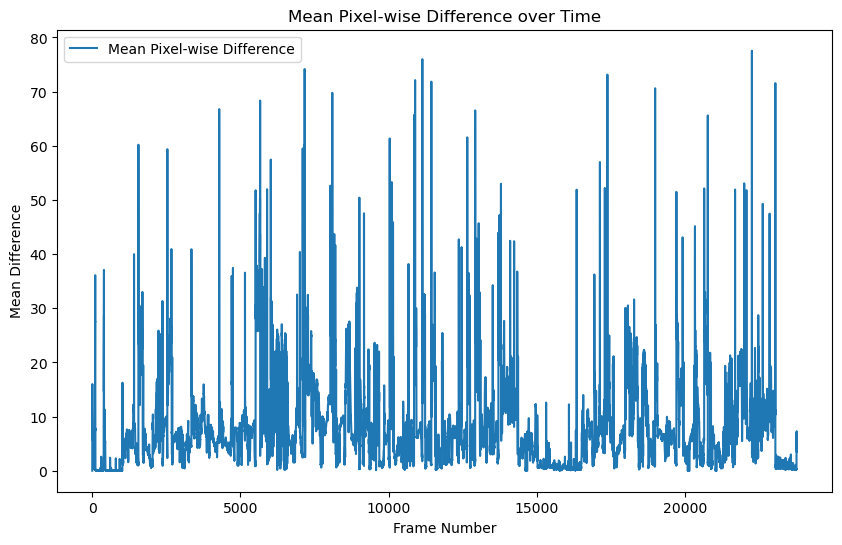

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(mean_differences, label='Mean Pixel-wise Difference')
plt.xlabel('Frame Number')
plt.ylabel('Mean Difference')
plt.title('Mean Pixel-wise Difference over Time')
plt.legend()
plt.show()